In [6]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub

In [0]:
from pathlib import Path
import re
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
sns.set()

import tensorflow as tf
import tensorflow_hub as hub
# Reduce logging output
from absl import logging
logging.set_verbosity(logging.ERROR)

In [0]:
# Inference model
MODULE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# Inference batch size
MAX_BATCH_SIZE = 1024

In [0]:
MAIN_DIR = Path('drive/My Drive/Colab Notebooks/transformers/MoviePlots')
DATA_FILE = MAIN_DIR/'data'/'data.pkl'

MODEL_DIR = MAIN_DIR/'text_generation'/'DistilGPT-2'
DUMPS_DIR = MODEL_DIR/'dumps'
CACHE_DIR = MODEL_DIR/'eval_cache'
CACHE_DIR.mkdir(exist_ok=True)

## Import training data

In [0]:
with open(DATA_FILE, 'rb') as handle:
    train_data = pickle.load(handle)

In [12]:
train_df = pd.DataFrame(train_data)

print(train_df.head())

                                               title  ...                      secondary
0                               "#7DaysLater" (2013)  ...                           None
1       "#BlackLove" (2015) {Crash the Party (#1.9)}  ...                Crash the Party
2  "#BlackLove" (2015) {Making Lemonade Out of Le...  ...  Making Lemonade Out of Lemons
3      "#BlackLove" (2015) {Miss Independent (#1.5)}  ...               Miss Independent
4     "#BlackLove" (2015) {Sealing the Deal (#1.10)}  ...               Sealing the Deal

[5 rows x 7 columns]


## Parse dumps

In [13]:
dump_files = list(DUMPS_DIR.glob('*.txt'))

dump_files

[PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/DistilGPT-2/dumps/temp_1_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/DistilGPT-2/dumps/temp_0_7_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/DistilGPT-2/dumps/temp_0_7_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/DistilGPT-2/dumps/temp_1_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/DistilGPT-2/dumps/temp_1_3_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/without-titles/DistilGPT-2/dumps/temp_1_3_topp_0_9.txt')]

In [0]:
BOS_TOKEN = '<|startoftext|>'
EOG_TOKEN = '<|endofgenre|>'
EOS_TOKEN = '<|endoftext|>'

In [0]:
def parse_sample(line):
    """Extract the data from a line generated by the model."""
    main = line.split(BOS_TOKEN)[1].split(EOS_TOKEN)[0]
    genre = main.split(EOG_TOKEN)[0].strip()
    plot = main.split(EOG_TOKEN)[1].strip()
    return {
        'genre': genre,
        'plot': plot
    }

In [0]:
def parse_fname(fname):
    """Parse the name of a file for temperature and top_p."""
    pattern = r'temp_(.+)_topp_(.+).txt'
    match = re.search(pattern, fname)
    temp, topp = match.groups()
    temp = float(temp.replace('_', '.'))
    topp = float(topp)
    return temp, topp

In [0]:
def parse_dumps(dump_files, overwrite=False):
    """Read dumps and parse them."""
    fpath = CACHE_DIR/'data.pkl'
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        with open(fpath, 'rb') as handle:
            return pd.DataFrame(pickle.load(handle))
    gen_data = []
    for dump_file in dump_files:
        with dump_file.open() as f:
            for line in f:
                try:
                    data_dict = parse_sample(line)
                    temp, topp = parse_fname(dump_file.name)
                    data_dict['temp'] = temp
                    data_dict['topp'] = topp
                    gen_data.append(data_dict)
                except:
                    pass
    with open(fpath, 'wb') as handle:
        pickle.dump(gen_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    gen_df = pd.DataFrame(gen_data)
    return gen_df

In [18]:
gen_df = parse_dumps(dump_files, overwrite=True)

print(gen_df.shape)
print(gen_df.head())

(1620, 4)
    genre                                               plot  temp  topp
0  action  PAUL FLUSH: When the medical examiner must rul...   1.0   0.0
1  action  A last-ditch attempt to create an take-down sa...   1.0   0.0
2  action  This isn't a very successful film. It's a lot ...   1.0   0.0
3  action  A Florida man is found dead and his daughter w...   1.0   0.0
4  action  Juri reveals to Elvira that he has a problem w...   1.0   0.0


## Calculate similarity

### Jaccard similarity

In [0]:
def jaccard_similarity(str1, str2):
    """Jacard similarity, or, how overfit is our data?..."""
    s1 = set(str1.split(' '))
    s2 = set(str2.split(' '))
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [0]:
def similarity_matrix(column, similarity_func, overwrite=False):
    """Calculate the pairwise similarity between texts of two lists."""
    # It's important to preserve the order of columns and index to compare multiple matrices later
    fpath = CACHE_DIR/(column + '.npz')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        # Do not forget to uncompress
        return np.load(fpath)['sim_matrix']
    pbar = tqdm(total=len(gen_df.index)*len(train_df.index))
    # Fill similarity matrix
    # We can compress our matrix to float16:
    # Since the values are always in [0, 1] with maximum step of 1/256 (for jaccard_similarity)
    sim_matrix = np.empty((len(gen_df.index), len(train_df.index)), dtype=np.float16)
    sim_matrix[:, :] = np.nan
    for i, t1 in enumerate(gen_df[column]):
        for j, t2 in enumerate(train_df[column]):
            if t1 not in (None, '') and t2 not in (None, ''):
                sim_matrix[i, j] = similarity_func(t1, t2)
            pbar.update()
    pbar.close()
    # Reduce file size by applying NumPy compression
    np.savez_compressed(fpath, sim_matrix=sim_matrix)
    return sim_matrix

In [21]:
# Plot similarity
plot_jm = similarity_matrix('plot', jaccard_similarity)

print(plot_jm.shape)

100%|██████████| 189852660/189852660 [1:38:09<00:00, 32235.71it/s]


(1620, 117193)


### Universal sentence encoder

In [0]:
# Load inference model
model = hub.load(MODULE_URL)

In [0]:
def compute_embeddings(texts, fname, overwrite=False):
    """Compute a representation for each text."""
    fpath = CACHE_DIR/(fname + '.npz')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        return np.load(fpath)['embeddings']
    embeddings = []
    for i in tqdm(range(0, len(texts), MAX_BATCH_SIZE)):
        embeddings.append(np.array(model(texts[i:i+MAX_BATCH_SIZE])))
    # np.inner has problems with np.float16
    embeddings = np.vstack(embeddings).astype(np.float32)
    assert(embeddings.shape[0] == len(texts))
    np.savez_compressed(fpath, embeddings=embeddings)
    return embeddings

In [24]:
gen_plot_embeddings = compute_embeddings(gen_df['plot'], 'gen_plot_embeddings')

print(gen_plot_embeddings.shape)

100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

(1620, 512)


In [25]:
train_plot_embeddings = compute_embeddings(train_df['plot'], 'train_plot_embeddings')

print(train_plot_embeddings.shape)

100%|██████████| 115/115 [01:28<00:00,  1.62it/s]


(117193, 512)


In [26]:
%%time
# Compute pairwise similarity
plot_em = np.inner(gen_plot_embeddings, train_plot_embeddings)

print(plot_em.shape)

(1620, 117193)
CPU times: user 5.97 s, sys: 310 ms, total: 6.28 s
Wall time: 1.82 s


### Stack matrices

In [27]:
# Stack matrices together
jm = np.stack([plot_jm, plot_em], axis=2)

print(jm.shape)

(1620, 117193, 2)


In [0]:

# Release RAM
del plot_jm
del gen_plot_embeddings
del train_plot_embeddings
del plot_em

In [29]:
# Check if some generated titles/plots are empty or NaN
gen_df['plot'].apply(lambda x: x not in (None, '')).all()

True

## Evaluate similarity

In [30]:
# Correlation of similarities on different stages
print(pd.DataFrame({
    'plot_jaccard': jm[:, :, 0].flatten(), 
    'plot_embed': jm[:, :, 1].flatten()
}).corr())

              plot_jaccard  plot_embed
plot_jaccard      1.000000    0.237772
plot_embed        0.237772    1.000000


### Maximum similarity per generated example

In [31]:
# For each generated sample, take the highest similarity found in the training dataset
maxsim_df = pd.DataFrame(jm.max(axis=1), columns=['plot_jaccard', 'plot_embed'], index=gen_df['plot'].tolist())

print(maxsim_df.head())

                                                    plot_jaccard  plot_embed
PAUL FLUSH: When the medical examiner must rule...      0.176514    0.532752
A last-ditch attempt to create an take-down sat...      0.158691    0.590942
This isn't a very successful film. It's a lot l...      0.141724    0.578107
A Florida man is found dead and his daughter wi...      0.187866    0.668621
Juri reveals to Elvira that he has a problem wi...      0.173950    0.542879


In [32]:
# The average similarity of generated plots to the real ones
maxsim_df.mean()

plot_jaccard    0.158375
plot_embed      0.605286
dtype: float32

In [33]:
# The number of exact matches
(maxsim_df == 1).mean()

plot_jaccard    0.0
plot_embed      0.0
dtype: float64

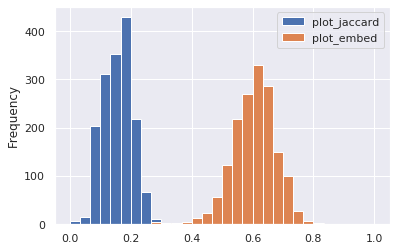

In [34]:
# Plot distribution of maximum similarity
maxsim_df.plot.hist(bins=30)

In [35]:
print(maxsim_df['plot_jaccard'].sort_values())

[news                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            0.000000
#fantasy                                                                                      

In [36]:
print(maxsim_df['plot_embed'].sort_values())

"filler                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Grouped by genre

In [37]:
GENRES = list(sorted(gen_df['genre'].unique()))

print(GENRES)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']


In [0]:
# Extract genre masks
gen_genre_masks = {}
for genre in GENRES:
    gen_genre_mask = gen_df.index.isin(gen_df[gen_df['genre'] == genre].index)
    gen_genre_masks[genre] = gen_genre_mask
train_genre_masks = {}
for genre in GENRES:
    train_genre_mask = train_df.index.isin(train_df[train_df['genres'].apply(lambda x: genre in x)].index)
    train_genre_masks[genre] = train_genre_mask

In [39]:
# How many examples in each genre
print(pd.DataFrame([(train_genre_masks[genre].sum(), gen_genre_masks[genre].sum()) 
for genre in GENRES], columns=['train', 'gen'], index=GENRES).sort_values(by='train', ascending=False))

             train  gen
drama        45890   60
comedy       33870   60
romance      19174   60
family       15403   60
crime        15120   60
action       12376   60
reality-tv   12336   60
mystery      12025   60
documentary  12020   60
animation    11369   60
adventure    10243   60
thriller      8852   60
sci-fi        8658   60
fantasy       7103   60
talk-show     5253   60
news          3945   60
music         2837   60
western       2761   60
history       2662   60
horror        2571   60
game-show     2045   60
sport         1946   60
war           1407   60
biography     1385   60
musical        595   60
short          578   60
adult           61   60


In [0]:
def compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks, another_gen_mask=None):
    """Calculate mean similarity for each pair of genres."""
    genre_sim = np.empty((len(GENRES), len(GENRES), jm.shape[2]))
    pbar = tqdm(total=len(GENRES)**2)
    for i, gen_genre in enumerate(GENRES):
        for j, train_genre in enumerate(GENRES):
            gen_mask = gen_genre_masks[gen_genre]
            train_mask = train_genre_masks[train_genre]
            if another_gen_mask is not None:
                gen_mask = gen_mask & another_gen_mask
            genre_sim[i, j] = jm[gen_mask, :, :][:, train_mask, :].mean(axis=0).mean(axis=0)
            pbar.update()
    pbar.close()
    return genre_sim

In [41]:
genre_sim = compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks)

100%|██████████| 729/729 [00:31<00:00, 23.16it/s]


In [0]:
def plot_genre_heatmap(genre_sim):
    """Plot the genre similarity matrix as a heatmap."""
    genre_sim_df = pd.DataFrame(genre_sim, columns=GENRES, index=GENRES)
    sorted_genres = genre_sim_df.mean().sort_values().index.tolist()
    plt.figure(figsize=(10, 8))
    sns.heatmap(genre_sim_df.loc[sorted_genres, sorted_genres], cmap="YlGnBu")
    plt.show()

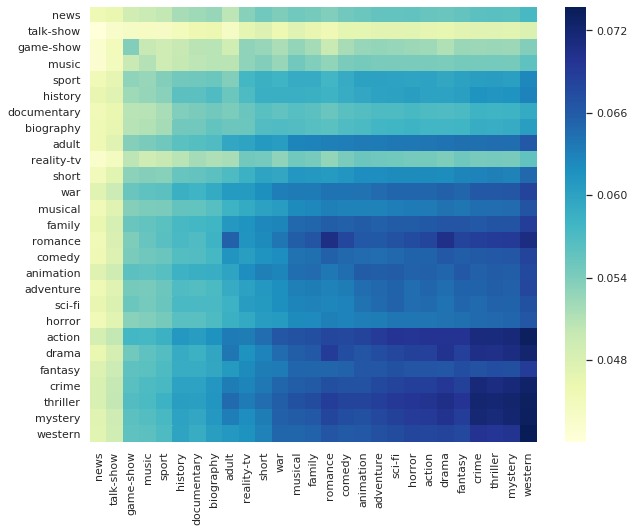

In [43]:
# Based on Jaccard similarity
# Generated plots are on the left, training plots on the bottom
# Dark horizontal lines mean the genre couldn't be learned sufficiently (few data?)
plot_genre_heatmap(genre_sim[:, :, 0])

In [44]:
# Average similarity between plots of the same genre
# Hints at expressiveness of each genre 
pd.Series(genre_sim[:, :, 0].diagonal(), index=GENRES).sort_values(ascending=False)

western        0.073701
mystery        0.072046
thriller       0.071863
crime          0.071570
romance        0.070852
drama          0.070045
action         0.069839
fantasy        0.067332
animation      0.065989
sci-fi         0.065436
family         0.065260
comedy         0.064988
adventure      0.064951
horror         0.063928
war            0.063279
musical        0.062296
short          0.059740
adult          0.059500
history        0.056129
biography      0.055672
reality-tv     0.054757
documentary    0.054276
sport          0.053756
game-show      0.053708
music          0.051073
news           0.045521
talk-show      0.043632
dtype: float64

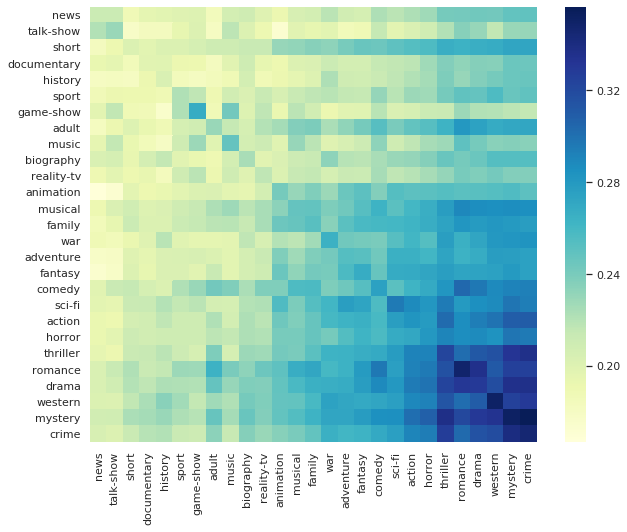

In [45]:
# Based on semantic similarity
# Dark points hint on semantics correlation of both genres
plot_genre_heatmap(genre_sim[:, :, 1])

In [46]:
pd.Series(genre_sim[:, :, 1].diagonal(), index=GENRES).sort_values(ascending=False)

mystery        0.351631
western        0.350757
romance        0.348238
crime          0.345552
drama          0.329432
thriller       0.322797
sci-fi         0.296135
action         0.282874
horror         0.280668
comedy         0.275560
game-show      0.268333
fantasy        0.267766
war            0.264942
adventure      0.254003
family         0.252521
musical        0.247812
music          0.247662
animation      0.241412
talk-show      0.229795
adult          0.229778
biography      0.224334
sport          0.222033
reality-tv     0.217007
news           0.212009
history        0.203750
short          0.202337
documentary    0.198352
dtype: float64

### Grouped by metrics

100%|██████████| 729/729 [00:10<00:00, 69.72it/s]


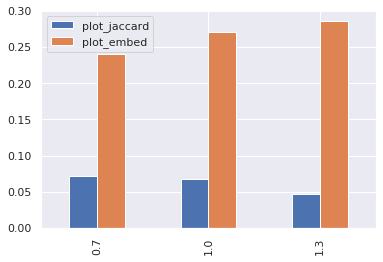

In [47]:
# For each temperature, calculate the avg similarity of plots of the same genre
genre_temp_sims = {}
for temp, group in gen_df.groupby(by='temp'):
    gen_mask = gen_df.index.isin(group.index).tolist()
    genre_temp_sim = compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks, another_gen_mask=gen_mask)
    genre_temp_sims[temp] = [genre_temp_sim[:, :, sim].diagonal().mean() for sim in range(genre_temp_sim.shape[2])]
pd.DataFrame(genre_temp_sims, index=['plot_jaccard', 'plot_embed']).transpose().plot.bar()

100%|██████████| 729/729 [00:15<00:00, 45.58it/s]


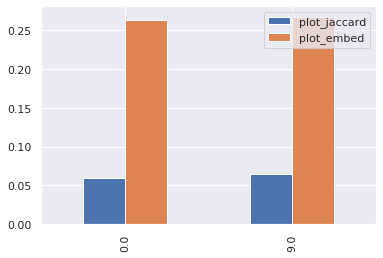

In [48]:
# For each top_p, calculate the avg similarity of plots of the same genre
genre_topp_sims = {}
for topp, group in gen_df.groupby(by='topp'):
    gen_mask = gen_df.index.isin(group.index).tolist()
    genre_topp_sim = compute_genre_simmatrix(jm, gen_genre_masks, train_genre_masks, another_gen_mask=gen_mask)
    genre_topp_sims[topp] = [genre_topp_sim[:, :, sim].diagonal().mean() for sim in range(genre_topp_sim.shape[2])]
pd.DataFrame(genre_topp_sims, index=['plot_jaccard', 'plot_embed']).transpose().plot.bar()

### The most similar example

In [0]:
# Display the most similar example according to universal embeddings
gen_i, train_i = np.unravel_index(np.argmax(jm[:, :, 1]), jm.shape[:2])

In [50]:
jm[gen_i, train_i, :]

array([0.984375  , 0.99999976], dtype=float32)

In [51]:
print(gen_df.iloc[gen_i])
print(gen_df.iloc[gen_i]['plot'])

genre                                                music
plot     This Hooper Award Winning show is designed wit...
temp                                                   0.7
topp                                                     0
Name: 416, dtype: object
This Hooper Award Winning show is designed with the whole family in mind. The show's host, Jimmie Jackson, known as "Television's Singing Troubadour" is accompanied by the "Memory Lane Orchestra" as they perform nostalgic songs from the past on a musical stroll down "Memory Lane." The show also features "Television's Hollywood Hostess," Anita Coleman who shares the latest Hollywood gossip with her exciting celebrity guests. Moppet, J.P. Sloane is also occasionally featured as "Hollywood's Youngest Television Host."


In [52]:
print(train_df.iloc[train_i])
print(train_df.iloc[train_i]['plot'])

title                      "Memory Lane" (1947) {(1947-07-04)}
plot          This Hooper Award Winning show is designed wi...
genres                                                 {music}
year                                                      1947
episode                                                   None
primary                                            Memory Lane
secondary                                                     
Name: 57427, dtype: object
 This Hooper Award Winning show is designed with the whole family in mind. The show's host, Jimmie Jackson, known as "Television's Singing Troubadour" is accompanied by the "Memory Lane Orchestra" as they perform nostalgic songs from the past on a musical stroll down "Memory Lane." The show also features "Television's Hollywood Hostess," Anita Coleman who shares the latest Hollywood gossip with her exciting celebrity guests. Moppet, J.P. Sloane is also occasionally featured as "Hollywood's Youngest Television Host."


### The least similar examples

In [0]:
# Sort generated texts by the mean of all their similarities
sorted_i = np.argsort(np.max(np.mean(jm, axis=2), axis=1))

In [54]:
print('\n'.join(gen_df.iloc[sorted_i[:5]]['plot'].tolist()))

"filler
(6 part)
[news
Check out The Enhancerous Ancients who passed through Air FIFA 13 online matches
The episode opens with a discussion of the effects of a test mouse on a man's heart. Then we see a demonstration of a tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic tic ti


In [55]:
print(gen_df.iloc[sorted_i[0]])
print(gen_df.iloc[sorted_i[0]]['plot'])

genre    musical
plot     "filler
temp         1.3
topp           0
Name: 1231, dtype: object
"filler
